<a href="https://colab.research.google.com/github/DataBytes-Organisation/Project-Echo/blob/ee%2Fjaje%2Fonboarding/birds_classification_01_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

## Efficient Image Loading and Labeling for Bird Species Classification

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import numpy as np

def load_images_from_path(base_path, birds):
    images = []
    labels = []
    for bird in birds:
        bird_path = os.path.join(base_path, bird)
        print(f"Looking in directory: {bird_path}")  # Debug: show the bird directory being checked

        if not os.path.exists(bird_path):
            print(f"Bird directory not found: {bird_path}")
            continue

        for root, dirs, files in os.walk(bird_path):
            for file in files:
                if file.endswith(('jpg', 'jpeg', 'png')):
                    img_path = os.path.join(root, file)
                    print(f"Loading image: {img_path}")  # Debug: show each image being loaded
                    img_loaded = load_img(img_path, target_size=(224, 224, 3))
                    img_array = img_to_array(img_loaded)
                    images.append(img_array)
                    labels.append(bird)

    return np.array(images), np.array(labels)

# Define the path and list of bird subfolders
drive_folder_path = 'F:/Jacob/Project_Echo/Images/'
birds = os.listdir(drive_folder_path)

# Load images and labels
images, labels = load_images_from_path(drive_folder_path, birds)

Looking in directory: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_11.250-13.250.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_11.750-13.750.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_12.800-14.800.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_13.250-15.250.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_14.750-16.050.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_16.750-18.750.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_17.600-19.600.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_17.750-19.750.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_18.500-20.500.png
Loading image: F:/Jacob/Project_Echo/Images/Acanthiza chrysorrhoa\region_22.750-24.750.png
Loading image: F:

In [ ]:
# Normalize the images
images = images / 255.0


## Label Encoding and One-Hot Encoding for Bird Species Classification

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)


## Cross-Validation Setup for Model Evaluation

In [ ]:
# Define cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to store results
all_val_accuracies = []
all_test_accuracies = []
all_classification_reports = []

## Function to Build a Convolutional Neural Network (CNN) Model

In [ ]:
# Function to build the CNN model
def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## Cross-Validation and Model Evaluation

In [ ]:
# Perform cross-validation
for train_index, val_index in kf.split(images):
    X_train, X_val = images[train_index], images[val_index]
    y_train, y_val = labels_one_hot[train_index], labels_one_hot[val_index]

    # Build and train the model
    model = build_model((224, 224, 3), len(birds))
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)

    # Evaluate on validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    all_val_accuracies.append(val_accuracy)

    # Make predictions on the validation set
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_val_classes = np.argmax(y_val, axis=1)

    # Store classification report
    report = classification_report(y_val_classes, y_pred_classes,
                                   target_names=label_encoder.classes_,
                                   labels=range(len(birds)),
                                   output_dict=True)

    all_classification_reports.append(report)

Epoch 1/10
128/128 [==============================] - 36s 105ms/step - loss: 3.6179 - accuracy: 0.2063 - val_loss: 2.7924 - val_accuracy: 0.3740
Epoch 2/10
128/128 [==============================] - 11s 85ms/step - loss: 2.5412 - accuracy: 0.3907 - val_loss: 2.1926 - val_accuracy: 0.5117
Epoch 3/10
128/128 [==============================] - 11s 86ms/step - loss: 1.8901 - accuracy: 0.5311 - val_loss: 1.7126 - val_accuracy: 0.6055
Epoch 4/10
128/128 [==============================] - 12s 95ms/step - loss: 1.3329 - accuracy: 0.6618 - val_loss: 1.4284 - val_accuracy: 0.6641
Epoch 5/10
128/128 [==============================] - 13s 100ms/step - loss: 0.9354 - accuracy: 0.7431 - val_loss: 1.3047 - val_accuracy: 0.6914
Epoch 6/10
128/128 [==============================] - 13s 100ms/step - loss: 0.6901 - accuracy: 0.8032 - val_loss: 1.3500 - val_accuracy: 0.7158
Epoch 7/10
128/128 [==============================] - 16s 127ms/step - loss: 0.4802 - accuracy: 0.8640 - val_loss: 1.3503 - val_accur

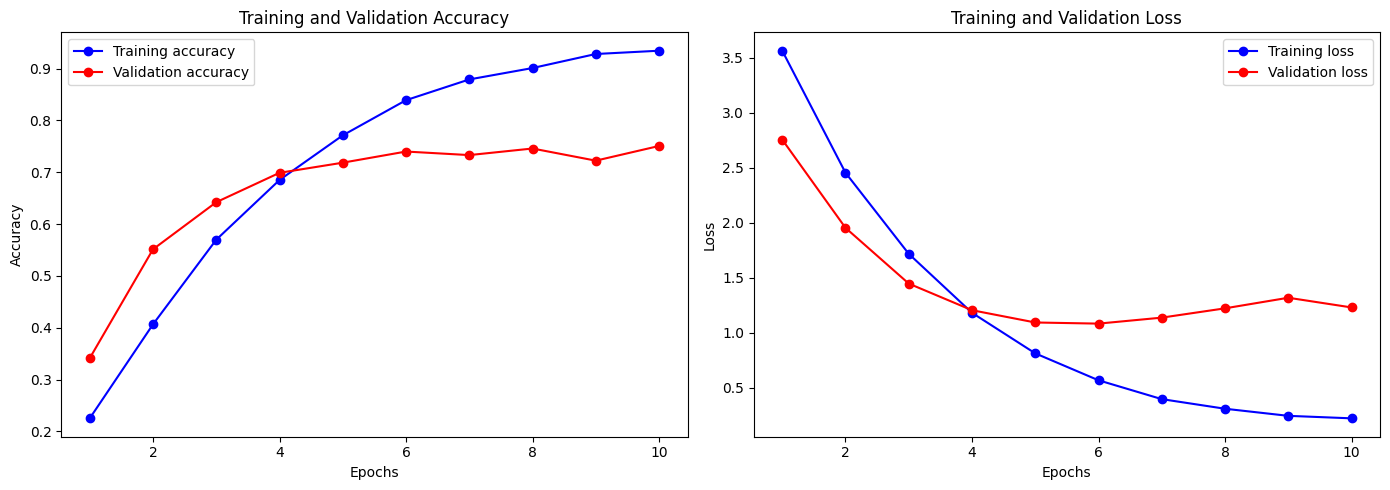

In [ ]:
# Plot training and validation metrics for the last fold
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history of the last fold
plot_training_history(history)


In [ ]:
# Print average validation accuracy
avg_val_accuracy = np.mean(all_val_accuracies)
print(f"Average validation accuracy: {avg_val_accuracy * 100:.2f}%")


Average validation accuracy: 74.06%


In [ ]:
# Print classification report for the last fold
print(classification_report(y_val_classes, y_pred_classes, target_names=label_encoder.classes_, labels=range(len(birds))))

                              precision    recall  f1-score   support

       Acanthiza chrysorrhoa       0.60      0.60      0.60         5
           Acanthiza lineata       1.00      0.67      0.80         3
              Acanthiza nana       0.82      1.00      0.90        27
           Acanthiza pusilla       0.57      0.68      0.62        37
        Acanthiza reguloides       0.75      0.90      0.82        30
       Acanthiza uropygialis       0.50      0.55      0.52        11
Acanthorhynchus tenuirostris       0.59      0.84      0.70        19
     Accipiter cirrocephalus       0.58      0.55      0.56        20
          Aidemosyne modesta       1.00      1.00      1.00         2
             Alauda arvensis       0.50      0.25      0.33         4
     Anhinga novaehollandiae       0.00      0.00      0.00         0
         Anthochaera phrygia       0.80      0.89      0.84         9
               Artamus minor       0.70      0.88      0.78         8
         Barnardius